## Project: Stroke prediction

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functions_sandbox as sand
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro, chi2_contingency, loguniform, randint
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_validate
from imblearn.over_sampling import RandomOverSampler

In [179]:
path = r"D:\IT_projects\Turing_Colledge\Modul3\Sprint2\project\healthcare-dataset-stroke-data.csv"
healthcare = pd.read_csv(path)

In [180]:
healthcare.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [181]:
healthcare.tail(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
5109,44679,Female,44.0,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


Firstly let's check basic info of given data

In [182]:
healthcare.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Most of Dtypes looks fine, only age Dtype could be converted to int.  
Feature named id doesn't seemed to have a value for analysis and might be  
removed.

### Data cleaning

I used my personal dataframe cleaning tool to check and clean basics of  
dataframe (duplicates, NaN, empty cells). Info=True shows what type of  
problem should be cleaned.

In [183]:
healthcare = sand.cleaner(healthcare, info=False)

Dataframe cleaner function showed that there are some NaN cells. So now let's  
check which and how many of these are

In [184]:
healthcare.isna().any()

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

Feature named bmi (body mass index) has NaN values that should be processed

In [185]:
healthcare["bmi"].isna().sum()

201

We can see that 201/5109 are NaN values in bmi feature which would be ~4%.  
It leaves us question what should we do with these values? The idea of dropping  
out 4% of data doesn't seem good, so I chose value imputation method.

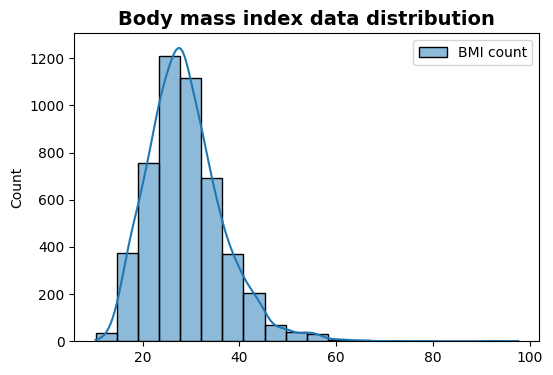

In [186]:
sand.f_histogram(
    xaxis=healthcare["bmi"],
    bins=20,
    kde=True,
    label="BMI count",
    title="Body mass index data distribution",
)

We can see BMI data is well distributed with most of the data 20-40 idx.  
Keeping this in mind we can use imputation method knowing it won't distort  
whole picture of data analysis.

In [187]:
imputer = SimpleImputer(strategy="mean")
healthcare["bmi"] = imputer.fit_transform(healthcare[["bmi"]])

After some bmi vales have been adjusted, next step is feature named age.  
It has float dtype which is usually unnecessary. Let's look why it could have  
this dtype

In [188]:
healthcare[(healthcare["age"] > 0) & (healthcare["age"] < 2)]["age"].unique()

array([1.32, 0.64, 0.88, 1.8 , 0.32, 1.08, 1.16, 1.  , 1.4 , 1.72, 0.24,
       1.64, 1.56, 0.72, 1.88, 1.24, 0.8 , 0.4 , 0.08, 1.48, 0.56, 0.48,
       0.16])

Apparently, most of the age values are whole numbers except numbers from  
0 to 2. Values in this interval are extracted to decimals. For now, I will  
convert these numbers to integers. If any interesting results would be seen  
in further analysis, these values (1, 2) will be reversed to floats for deeper  
analysis

In [189]:
# Copy of healthcare dataframe
hc = healthcare.copy()

hc["age"] = hc["age"].astype(int)

In [190]:
hc["gender"].value_counts()

gender
Female    2994
Male      2115
Other        1
Name: count, dtype: int64

We see value Other in feature named Gender. Because it's only one row  
and will not have strong impact to analysis, it can be removed

In [191]:
hc = hc.loc[hc["gender"] != "Other"]

In [192]:
hc["work_type"].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

We can see on work type feature there are 5 string typeclasses. We can clean  
them to be more convenient to work with.  
Also, I checked smoking status value numbers and strings looks

In [193]:
# replace column's strings
hc["work_type"] = hc["work_type"].replace(
    {
        "Private": "private",
        "Self-employed": "self_employed",
        "Govt_job": "gvt_job",
        "children": "child_care",
        "Never_worked": "never_worked",
    }
)

# count values of each column's class
hc["smoking_status"].value_counts()

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: count, dtype: int64

We can see 4 classes of smoking status feature with the first place  
never_smoked and second unknown. The unknown class might be a problem in  
further research if smoking status feature had strong impact to ML models.

In [194]:
# replace column's strings
hc["smoking_status"] = hc["smoking_status"].replace(
    {
        "formerly smoked":"fmly_smoked",
        "never smoked":"never_smoked",
        "smokes":"smokes",
        "Unknown":"unknown"
    }
)

# id column drop
hc = hc.drop(columns="id")

# lower case strings
hc["residence_type"] = hc["residence_type"].str.lower()

### EDA (Exploratory Data Analysis)

Since I did some changes in dataframe, let's check again basic info of cleaned  
dataframe

In [197]:
hc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5109 non-null   object 
 1   age                5109 non-null   int32  
 2   hypertension       5109 non-null   int64  
 3   heart_disease      5109 non-null   int64  
 4   ever_married       5109 non-null   object 
 5   work_type          5109 non-null   object 
 6   residence_type     5109 non-null   object 
 7   avg_glucose_level  5109 non-null   float64
 8   bmi                5109 non-null   float64
 9   smoking_status     5109 non-null   object 
 10  stroke             5109 non-null   int64  
dtypes: float64(2), int32(1), int64(3), object(5)
memory usage: 459.0+ KB


By looking into table we can split data to categorical and numerical for  
future analysis

In [202]:
numeric = ["age", "hypertension", "heart_disease", "avg_glucose_level", "bmi", "stroke"]
categoric = ["gender", "ever_married", "work_type", "residence_type", "smoking_status"]
hc_num = hc[numeric]
hc_cat = hc[categoric]